# Data Modeling

---

## Purpose

This notebook builds and evaluates machine learning models to predict income levels.

- Apply undersampling to handle class imbalance
- Split data into training and testing sets
- Build scikit-learn pipelines for preprocessing and modeling
- Train and evaluate 6 different classification models
- Extract and visualize top important features
- Compare model performance across all algorithms
- Generate SHAP plots for the best performing model to explain predictions

---

In [1]:
!pip install -r ../requirements.txt -q

In [2]:
# import packages
import numpy as np
import pandas as pd
import warnings
import os

# ignore warnings
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit Learn
import sklearn
from sklearn.impute import SimpleImputer

# Pipelines
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    RobustScaler,
    FunctionTransformer,
)
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    HistGradientBoostingClassifier,
)
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting

# Metrics
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    precision_score,
    brier_score_loss,
    recall_score,
    roc_curve,
    roc_auc_score,
)

# HP Tunings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Bayesian Search
from skopt.space import Integer, Categorical, Real
from skopt import BayesSearchCV

# Shap Values
import shap

# Resampling
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

import pickle

from utils import *

In [3]:
# load file
df = pd.read_parquet("../data/processed_data.parquet")
df.head(2)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,...,country_of_birth_father_is_usa,country_of_birth_mother_is_usa,country_of_birth_self_is_usa,sex_is_male,has_capital_gains,has_capital_losses,has_dividends_from_stocks,capital_gains_log,capital_losses_log,dividends_from_stocks_log
0,73,not in universe,0,0,0,not in universe,widowed,not in universe or children,not in universe,white,...,1,1,1,0,0,0,0,0.0,0.0,0.0
1,58,self-employed-not incorporated,4,34,0,not in universe,divorced,construction,precision production craft & repair,white,...,1,1,1,1,0,0,0,0.0,0.0,0.0


In [4]:
# add a random variable for for variable selection
df["random_variable"] = np.random.rand(len(df))
df["random_variable"].mean()

0.5000910958934166

In [5]:
continuous = []
categorical_less_than_10_cat = []
categorical_more_than_9_cat = []

for column in df.columns:
    if df[column].dtype == "int64" or df[column].dtype == "float64":
        if column not in [
            "label",
            "weight",
            "detailed_industry_recode",
            "detailed_occupation_recode",
            "year",
        ]:
            continuous.append(column)

    elif df[column].dtype == "object":
        if column not in ["detailed_household_and_family_stat"]:
            if df[column].nunique() < 10:
                categorical_less_than_10_cat.append(column)

            if df[column].nunique() > 10:
                categorical_more_than_9_cat.append(column)

print("\nContinuous Columns:", continuous)
print("\nCategorical Columns (Less than 10 categories):", categorical_less_than_10_cat)
print("\nCategorical Columns (More than 9 categories):", categorical_more_than_9_cat)


Continuous Columns: ['age', 'wage_per_hour', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'education_numeric', 'country_of_birth_father_is_usa', 'country_of_birth_mother_is_usa', 'country_of_birth_self_is_usa', 'sex_is_male', 'has_capital_gains', 'has_capital_losses', 'has_dividends_from_stocks', 'capital_gains_log', 'capital_losses_log', 'dividends_from_stocks_log', 'random_variable']

Categorical Columns (Less than 10 categories): ['class_of_worker', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'race', 'hispanic_origin', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'family_members_under_

In [6]:
# columns for target encoding, one hot encoding and numeric
cols_for_target_encoding = categorical_more_than_9_cat
cols_for_numeric = continuous
cols_for_dummies = categorical_less_than_10_cat
weight_col = "weight"

In [7]:
cols_to_filter = cols_for_target_encoding + cols_for_numeric + cols_for_dummies
df = shuffle(df).reset_index(drop=True)

target_model = df["label"]
df_final_model = df[cols_to_filter]
sample_weights = df[weight_col]

In [8]:
# Undersampling

n_minority = (target_model == 1).sum()
n_majority = (target_model == 0).sum()

target_event_rate = 0.10
sampling_strategy = target_event_rate / (1 - target_event_rate)

print(f"\nTarget event rate: {target_event_rate:.2%}")
print(f"Required sampling_strategy: {sampling_strategy:.6f}")

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_under_sampled, y_under_sampled = rus.fit_resample(df_final_model, target_model)

undersampled_indices = rus.sample_indices_
weights_under_sampled = sample_weights.iloc[undersampled_indices].values

print(f"\nObservations prior to Under Sampling: {df_final_model.shape[0]}")
print(f"Observations after Under Sampling: {X_under_sampled.shape[0]}")
print(f"\nOriginal dataset >$50K Income rate: {target_model.mean():2%}")
print(
    f"Original dataset weighted >$50K Income rate: {np.average(target_model, weights=sample_weights):.2%}"
)
print(f"\nUnderSampled dataset >$50K Income rate: {y_under_sampled.mean():.2%}")
print(
    f"UnderSampled dataset weighted >$50K Income rate: {np.average(y_under_sampled, weights=weights_under_sampled):.2%}"
)


Target event rate: 10.00%
Required sampling_strategy: 0.111111

Observations prior to Under Sampling: 199523
Observations after Under Sampling: 123819

Original dataset >$50K Income rate: 6.205801%
Original dataset weighted >$50K Income rate: 6.41%

UnderSampled dataset >$50K Income rate: 10.00%
UnderSampled dataset weighted >$50K Income rate: 10.30%


In [9]:
# Stratified Train-Test Split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_under_sampled,
    y_under_sampled,
    weights_under_sampled,
    test_size=0.2,
    random_state=42,
    stratify=y_under_sampled,
)

print(f"Training datset: {X_train.shape[0]}")
print(f"Test dataset: {X_test.shape[0]}")
print(f"\nTraining unweighted event rate: {y_train.mean():.2%}")
print(f"Training weighted event rate: {np.average(y_train, weights=weights_train):.2%}")
print(f"\nTest unweighted event rate: {y_test.mean():.2%}")
print(f"Test weighted event rate: {np.average(y_test, weights=weights_test):.2%}")

Training datset: 99055
Test dataset: 24764

Training unweighted event rate: 10.00%
Training weighted event rate: 10.28%

Test unweighted event rate: 10.00%
Test weighted event rate: 10.35%


In [10]:
# Pipeline for Model

numeric_pipeline = make_pipeline(SimpleImputer(strategy="mean"), RobustScaler())

ohe_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="not in universe"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

target_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="not in universe"),
    TargetEncoder(
        handle_unknown="ignore",
        handle_missing="value",
    ),
)

processing = make_column_transformer(
    (numeric_pipeline, cols_for_numeric),
    (ohe_pipeline, cols_for_dummies),
    (target_pipeline, cols_for_target_encoding),
    remainder="drop",
)

processing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['age', 'wage_per_hour',
                                  'num_persons_worked_for_employer',
                                  'own_business_or_self_employed',
                                  'veterans_benefits', 'weeks_worked_in_year',
                                  'education_numeric',
                                  'country_of_birth_father_is_usa',
                                  'country_of_birth_mother_is_usa',
                                  'c...
                                  'live_in_this_house_1_year_ago',
                                  'migration_prev_res_in_sunbelt',
                                  'family_members_under_18', 'citizenship',
                                  "fill_inc_questionnaire_for_veteran's_admin"]),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='not '
                                                                           'in '
                                                                           'universe',
                                                                strategy='constant')),
                                                 ('targetencoder',
                                                  TargetEncoder(handle_unknown='ignore'))]),
                                 ['major_industry_code',
                                  'major_occupation_code'])])

**Target encoding** is used for all columns with less than 10 categories. The variables are 'vendor' and 'merchantCategoryCode'

**One Hot encoding** is used for the columns with more than 10 categories. The variables are 'posEntryMode', 'acqCountry', 'transactionType', 'posConditionCode', 'merchantCountryCode'

The others are **numeric features** which includes 'creditLimit', 'availableMoney', 'transactionAmount', 'percentage_transaction_amount', 'prev_customer_fraud', 'last_address_change', 'days_since_transaction', 'expiry_days_left', 'cardPresent', 'check_cvv', 'random_variable'

In [11]:
model = []
train_auc_, test_auc_ = [], []
train_accuracy_, test_accuracy_ = [], []
train_precision_, test_precision_ = [], []
train_recall_, test_recall_ = [], []
train_f1_score_, test_f1_score_ = [], []
optimal_hyperparameters_ = []

### Model 1: Logistic Regression

In [12]:
logistic_regression_model = make_pipeline(
    processing,
    LogisticRegressionCV(
        cv=2,
        max_iter=1000,
        penalty="l2",
        solver="lbfgs",
    ),
)
logistic_regression_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                                                   'citizenship',
                                                   "fill_inc_questionnaire_for_veteran's_admin"]),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='not '
                                                                                            'in '
                                                                                            'universe',
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder(handle_unknown='ignore'))]),
                                                  ['major_industry_code',
                                                   'major_occupation_code'])])),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=2, max_iter=1000))])

In [13]:
logistic_regression_model_object = logistic_regression_model.fit(
    X_train, y_train, logisticregressioncv__sample_weight=weights_train
)

In [14]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, logistic_regression_model_object
)

Train accuracy is - 0.932795
Test accuracy is - 0.930665
Train F1 score is - 0.602923
Test F1 score is - 0.590313


Train AUC ROC is - 0.944605
Test AUC ROC is - 0.941170


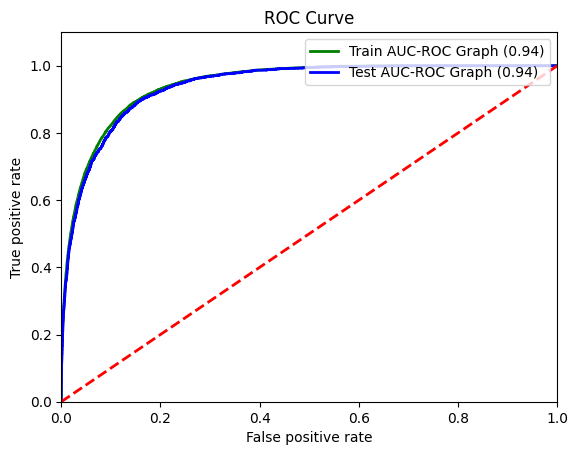

In [15]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, logistic_regression_model_object
)

Train Precision is - 0.736842
Train Recall is - 0.510196
Test Precision is - 0.721283
Test Recall is - 0.499596


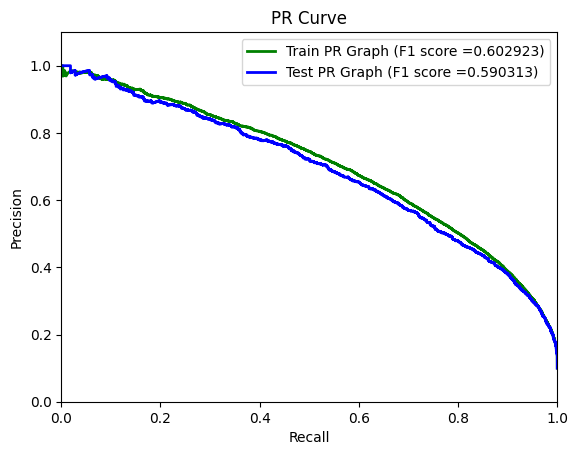

In [16]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, logistic_regression_model_object
)

In [17]:
model.append("Logistic Regression")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append("N/A")

In [18]:
os.makedirs("../artifacts/model_objects/", exist_ok=True)
with open("../artifacts/model_objects/logistic_regression_model.pkl", "wb") as file:
    pickle.dump(logistic_regression_model_object, file)

### Model 2: Naive Bayes

In [19]:
#### Model-2: Naive Bayes
naive_bayes_model = make_pipeline(processing, GaussianNB())

naive_bayes_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                                                   'migration_prev_res_in_sunbelt',
                                                   'family_members_under_18',
                                                   'citizenship',
                                                   "fill_inc_questionnaire_for_veteran's_admin"]),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='not '
                                                                                            'in '
                                                                                            'universe',
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder(handle_unknown='ignore'))]),
                                                  ['major_industry_code',
                                                   'major_occupation_code'])])),
                ('gaussiannb', GaussianNB())])

In [20]:
naive_bayes_model_object = naive_bayes_model.fit(
    X_train, y_train, gaussiannb__sample_weight=weights_train
)

In [21]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, naive_bayes_model_object
)

Train accuracy is - 0.600212
Test accuracy is - 0.594977
Train F1 score is - 0.317307
Test F1 score is - 0.313108


Train AUC ROC is - 0.804567
Test AUC ROC is - 0.800686


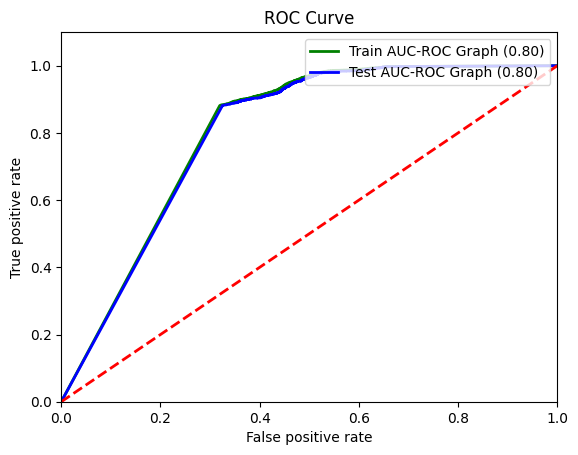

In [22]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, naive_bayes_model_object
)

Train Precision is - 0.191327
Train Recall is - 0.929033
Test Precision is - 0.188521
Test Recall is - 0.923263


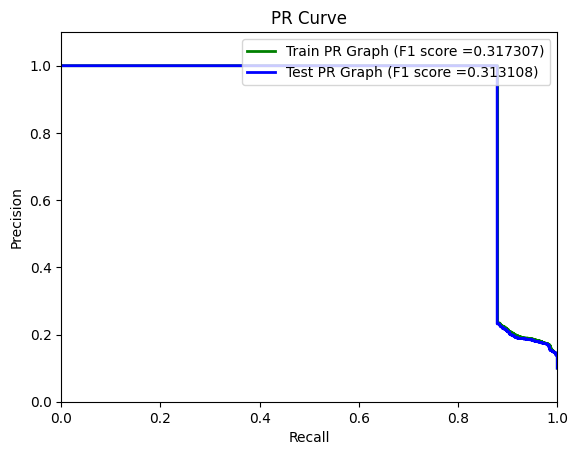

In [23]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, naive_bayes_model_object
)

In [24]:
model.append("Naive Bayes")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append("N/A")

In [25]:
with open("../artifacts/model_objects/naive_bayes_model.pkl", "wb") as file:
    pickle.dump(naive_bayes_model_object, file)

### Model 3: Decision Tree

In [26]:
search_spaces = {
    "max_depth": Integer(5, 9),
    "ccp_alpha": Real(1e-6, 20, prior="uniform"),
}

decision_tree_model = make_pipeline(
    processing,
    BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        search_spaces=search_spaces,
        n_jobs=-1,
        cv=2,
    ),
)
decision_tree_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                                                                   TargetEncoder(handle_unknown='ignore'))]),
                                                  ['major_industry_code',
                                                   'major_occupation_code'])])),
                ('bayessearchcv',
                 BayesSearchCV(cv=2,
                               estimator=DecisionTreeClassifier(random_state=42),
                               n_jobs=-1,
                               search_spaces={'ccp_alpha': Real(low=1e-06, high=20, prior='uniform', transform='identity'),
                                              'max_depth': Integer(low=5, high=9, prior='uniform', transform='identity')}))])

In [27]:
decision_tree_model_object = decision_tree_model.fit(
    X_train, y_train, bayessearchcv__sample_weight=weights_train
)

In [28]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, decision_tree_model_object
)

Train accuracy is - 0.936732
Test accuracy is - 0.929212
Train F1 score is - 0.649634
Test F1 score is - 0.605802


Train AUC ROC is - 0.943301
Test AUC ROC is - 0.925409


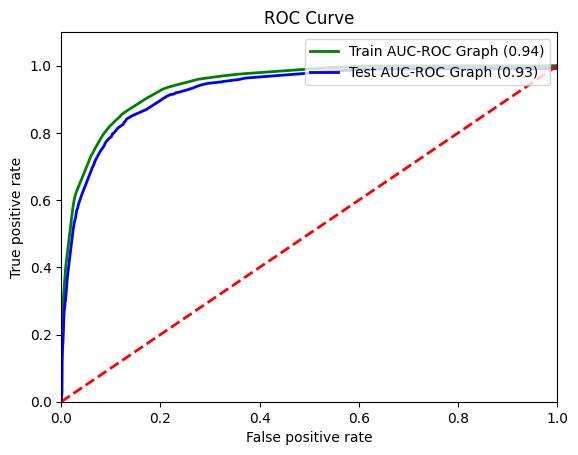

In [29]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, decision_tree_model_object
)

Train Precision is - 0.727979
Train Recall is - 0.586513
Test Precision is - 0.683409
Test Recall is - 0.544023


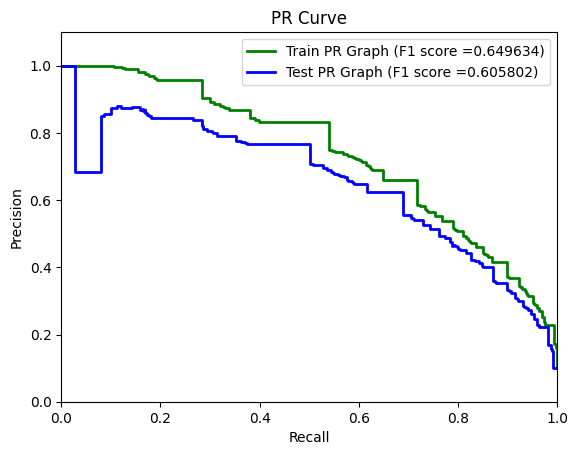

In [30]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, decision_tree_model_object
)

In [31]:
print("Optimal hyperparameters for DecisionTree model are:")
print(decision_tree_model_object.named_steps["bayessearchcv"].best_params_)
optimal_model_object = decision_tree_model_object.named_steps[
    "bayessearchcv"
].best_estimator_

Optimal hyperparameters for DecisionTree model are:
OrderedDict({'ccp_alpha': 1e-06, 'max_depth': 9})


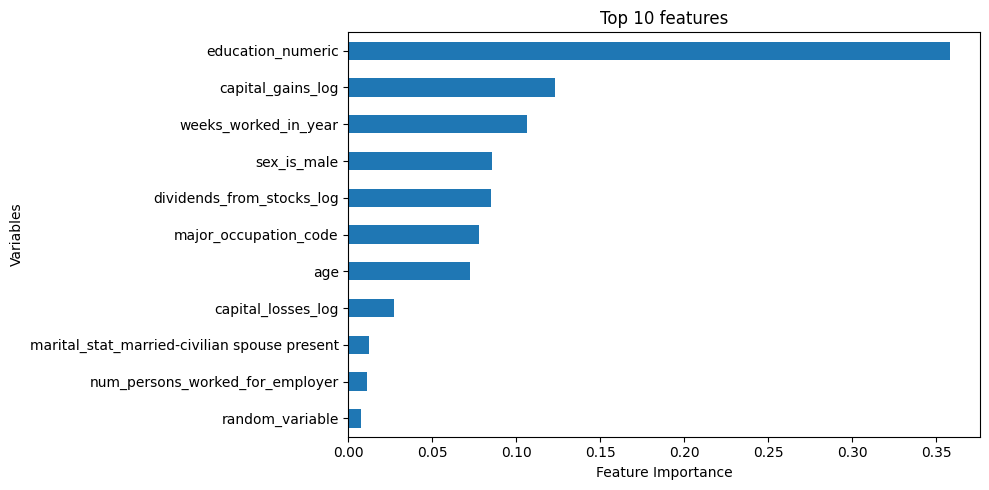

In [32]:
features = top_features(
    processing, decision_tree_model_object, cols_for_numeric, cols_for_target_encoding
)

In [33]:
model.append("Decision Tree")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append(
    decision_tree_model_object.named_steps["bayessearchcv"].best_params_
)

In [34]:
with open("../artifacts/model_objects/decision_tree_model.pkl", "wb") as file:
    pickle.dump(decision_tree_model_object, file)

### Model 4: Histogram-based GBM

In [35]:
search_spaces = {
    "l2_regularization": Real(1e-6, 10, prior="uniform"),
    "max_depth": Integer(5, 10),
    "learning_rate": Real(1e-3, 0.5, prior="uniform"),
}

historgram_gbm_model = make_pipeline(
    processing,
    BayesSearchCV(
        HistGradientBoostingClassifier(random_state=80, warm_start=True),
        search_spaces=search_spaces,
        cv=2,
        n_jobs=-1,
    ),
)

historgram_gbm_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                 BayesSearchCV(cv=2,
                               estimator=HistGradientBoostingClassifier(random_state=80,
                                                                        warm_start=True),
                               n_jobs=-1,
                               search_spaces={'l2_regularization': Real(low=1e-06, high=10, prior='uniform', transform='identity'),
                                              'learning_rate': Real(low=0.001, high=0.5, prior='uniform', transform='identity'),
                                              'max_depth': Integer(low=5, high=10, prior='uniform', transform='identity')}))])

In [36]:
historgram_gbm_model_object = historgram_gbm_model.fit(
    X_train, y_train, bayessearchcv__sample_weight=weights_train
)

In [37]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, historgram_gbm_model_object
)

Train accuracy is - 0.943658
Test accuracy is - 0.936723
Train F1 score is - 0.681104
Test F1 score is - 0.638857


Train AUC ROC is - 0.962087
Test AUC ROC is - 0.950175


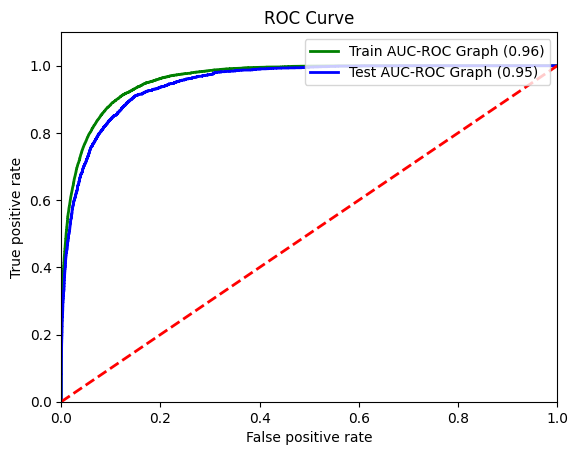

In [38]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, historgram_gbm_model_object
)

Train Precision is - 0.784727
Train Recall is - 0.601656
Test Precision is - 0.743961
Test Recall is - 0.559774


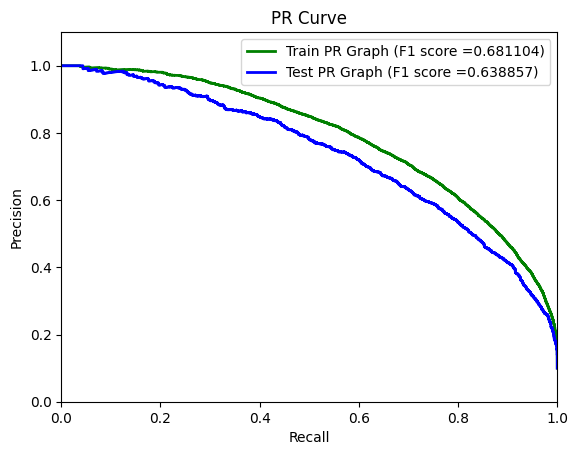

In [39]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, historgram_gbm_model_object
)

In [40]:
print("Optimal hyperparameters for Histogram-based GBM model are:")
print(historgram_gbm_model_object.named_steps["bayessearchcv"].best_params_)
optimal_model_object = historgram_gbm_model_object.named_steps[
    "bayessearchcv"
].best_estimator_

Optimal hyperparameters for Histogram-based GBM model are:
OrderedDict({'l2_regularization': 9.939861964160476, 'learning_rate': 0.13318013510307308, 'max_depth': 6})


In [41]:
model.append("Histogram-based GBM")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append(
    historgram_gbm_model_object.named_steps["bayessearchcv"].best_params_
)

In [42]:
with open("../artifacts/model_objects/historgram_gbm_model.pkl", "wb") as file:
    pickle.dump(historgram_gbm_model_object, file)

### Model 5: Random Forest

In [43]:
search_spaces = {
    "max_features": ["log2", "sqrt"],
    "max_depth": stats.randint(5, 8),
    "n_estimators": stats.randint(200, 400),
}

random_forest_model = make_pipeline(
    processing,
    RandomizedSearchCV(
        RandomForestClassifier(random_state=42, warm_start=True),
        param_distributions=search_spaces,
        n_jobs=-1,
        cv=2,
    ),
)

random_forest_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=2,
                                    estimator=RandomForestClassifier(random_state=42,
                                                                     warm_start=True),
                                    n_jobs=-1,
                                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3099cade0>,
                                                         'max_features': ['log2',
                                                                          'sqrt'],
                                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x32eb15280>}))])

In [44]:
random_forest_model_object = random_forest_model.fit(
    X_train, y_train, randomizedsearchcv__sample_weight=weights_train
)

In [45]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, random_forest_model_object
)

Train accuracy is - 0.922679
Test accuracy is - 0.921943
Train F1 score is - 0.412698
Test F1 score is - 0.399503


Train AUC ROC is - 0.942320
Test AUC ROC is - 0.937707


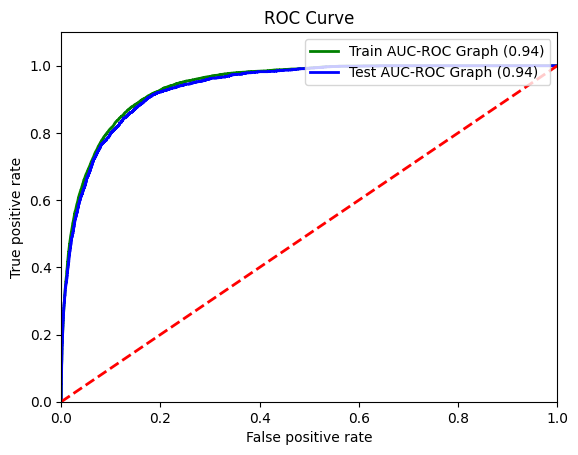

In [46]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, random_forest_model_object
)

Train Precision is - 0.858373
Train Recall is - 0.271654
Test Precision is - 0.865410
Test Recall is - 0.259693


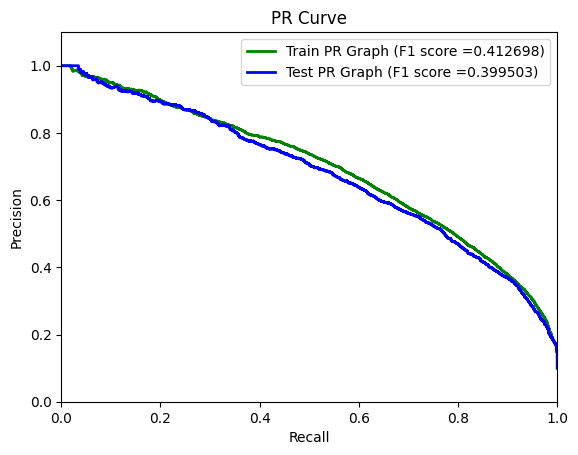

In [47]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, random_forest_model_object
)

In [48]:
print("Optimal hyperparameters for RandomForest model are:")
print(random_forest_model_object.named_steps["randomizedsearchcv"].best_params_)
optimal_model_object = random_forest_model_object.named_steps[
    "randomizedsearchcv"
].best_estimator_

Optimal hyperparameters for RandomForest model are:
{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 278}


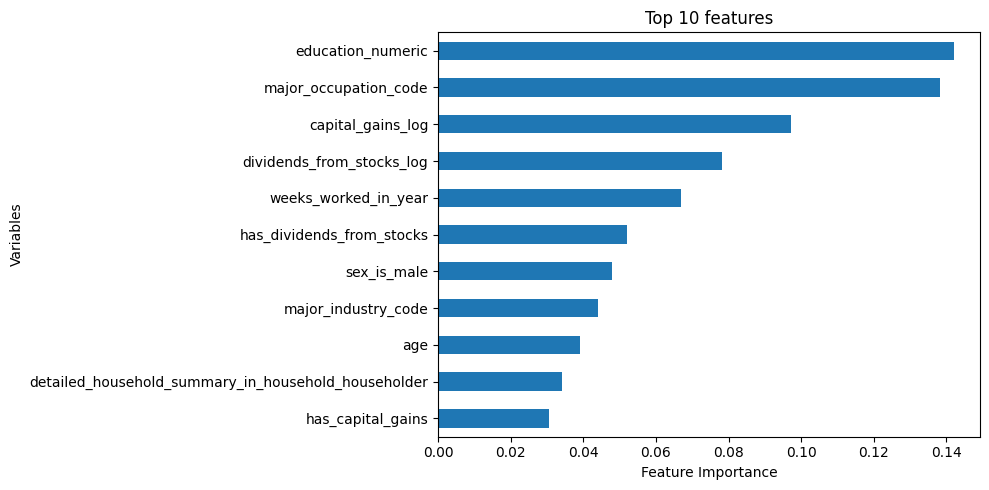

In [49]:
features = top_features(
    processing, random_forest_model_object, cols_for_numeric, cols_for_target_encoding
)

In [50]:
model.append("Random Forest")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append(
    random_forest_model_object.named_steps["randomizedsearchcv"].best_params_
)

In [51]:
with open("../artifacts/model_objects/random_forest_model.pkl", "wb") as file:
    pickle.dump(random_forest_model_object, file)

### Model 6: XGBoost

In [52]:
search_spaces = {
    "max_depth": Integer(2, 10),
    "reg_alpha": Real(1e-6, 10, prior="uniform"),
    "colsample_bytree": Real(0.1, 0.5, prior="uniform"),
    "learning_rate": Real(1e-6, 0.6, prior="uniform"),
    "gamma": Real(1e-6, 10, prior="uniform"),
    "reg_lambda": Real(1e-6, 10, prior="uniform"),
    "subsample": Real(0.2, 0.6, prior="uniform"),
    "n_estimators": Integer(300, 700),
    "min_child_weight": Integer(2, 200),
}

xgboost_model = make_pipeline(
    processing,
    BayesSearchCV(
        XGBClassifier(random_state=80), search_spaces=search_spaces, cv=2, n_jobs=-1
    ),
)
xgboost_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'wage_per_hour',
                                                   'num_persons_worked_for_employer',
                                                   'own_business_or_self_employed',
                                                   'veterans_benefits',
                                                   'weeks_worked_in_year',
                                                   'education_numeric',
                                                   'country_of_birth_father_is_usa...
                                              'min_child_weight': Integer(low=2, high=200, prior='uniform', transform='identity'),
                                              'n_estimators': Integer(low=300, high=700, prior='uniform', transform='identity'),
                                              'reg_alpha': Real(low=1e-06, high=10, prior='uniform', transform='identity'),
                                              'reg_lambda': Real(low=1e-06, high=10, prior='uniform', transform='identity'),
                                              'subsample': Real(low=0.2, high=0.6, prior='uniform', transform='identity')}))])

In [53]:
xgboost_model_object = xgboost_model.fit(
    X_train, y_train, bayessearchcv__sample_weight=weights_train
)

In [54]:
train_accuracy, test_accuracy, train_f1, test_f1 = get_metrics_(
    X_train, y_train, X_test, y_test, xgboost_model_object
)

Train accuracy is - 0.945707
Test accuracy is - 0.937813
Train F1 score is - 0.691239
Test F1 score is - 0.643188


Train AUC ROC is - 0.964949
Test AUC ROC is - 0.951814


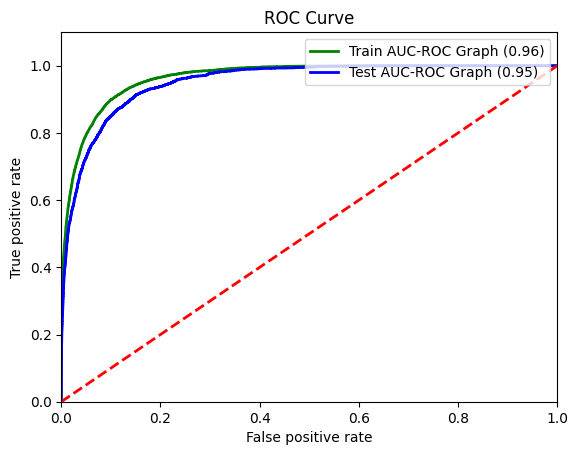

In [55]:
train_auc, test_auc = get_auc_roc_curve(
    X_train, y_train, X_test, y_test, xgboost_model_object
)

Train Precision is - 0.801384
Train Recall is - 0.607712
Test Precision is - 0.754348
Test Recall is - 0.560582


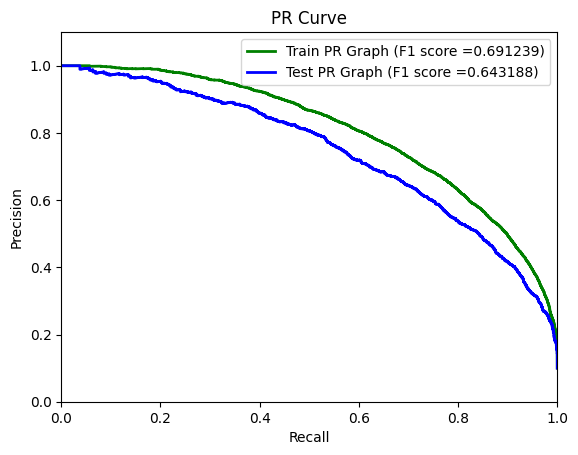

In [56]:
train_precision, test_precision, train_recall, test_recall = get_precision_recall_curve(
    X_train, y_train, X_test, y_test, xgboost_model_object
)

In [57]:
print("Optimal hyperparameters for XgBoost models are:")
print(xgboost_model_object.named_steps["bayessearchcv"].best_params_)
optimal_model_object = xgboost_model_object.named_steps["bayessearchcv"].best_estimator_

Optimal hyperparameters for XgBoost models are:
OrderedDict({'colsample_bytree': 0.23843571032975752, 'gamma': 7.581150814883322, 'learning_rate': 0.08491249344275414, 'max_depth': 5, 'min_child_weight': 185, 'n_estimators': 309, 'reg_alpha': 9.224983556909365, 'reg_lambda': 9.876999877579431, 'subsample': 0.5771974391967927})


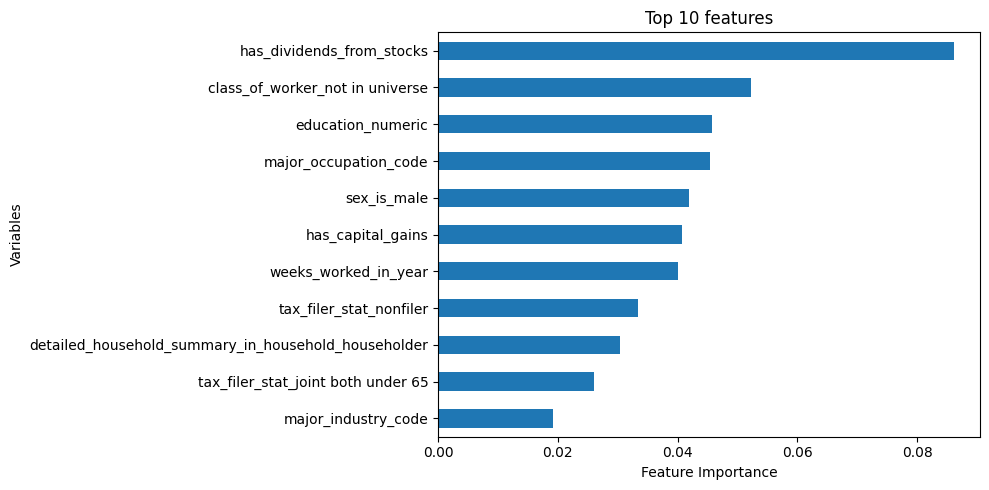

In [58]:
feature_names = top_features(
    processing, xgboost_model_object, cols_for_numeric, cols_for_target_encoding
)

In [59]:
model.append("XGBoost")
train_auc_.append(train_auc)
test_auc_.append(test_auc)
train_accuracy_.append(train_accuracy)
test_accuracy_.append(test_accuracy)
train_precision_.append(train_precision)
test_precision_.append(test_precision)
train_recall_.append(train_recall)
test_recall_.append(test_recall)
train_f1_score_.append(train_f1)
test_f1_score_.append(test_f1)
optimal_hyperparameters_.append(
    xgboost_model_object.named_steps["bayessearchcv"].best_params_
)

In [60]:
with open("../artifacts/model_objects/xgboost_model.pkl", "wb") as file:
    pickle.dump(xgboost_model_object, file)

### Final Comparison

In [61]:
df_output = pd.DataFrame(
    {
        "model": model,
        "train_auc": train_auc_,
        "test_auc": test_auc_,
        "train_accuracy": train_accuracy_,
        "test_accuracy": test_accuracy_,
        "train_precision": train_precision_,
        "test_precision": test_precision_,
        "train_recall": train_recall_,
        "test_recall": test_recall_,
        "train_f1_score": train_f1_score_,
        "test_f1_score": test_f1_score_,
        "optimal_hyperparameters": optimal_hyperparameters_,
    }
)
df_output

,model,train_auc,test_auc,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score,optimal_hyperparameters
0,Logistic Regression,0.944605,0.941170,0.932795,0.930665,0.736842,0.721283,0.510196,0.499596,0.602923,0.590313,N/A
1,Naive Bayes,0.804567,0.800686,0.600212,0.594977,0.191327,0.188521,0.929033,0.923263,0.317307,0.313108,N/A
2,Decision Tree,0.943301,0.925409,0.936732,0.929212,0.727979,0.683409,0.586513,0.544023,0.649634,0.605802,"{'ccp_alpha': 1e-06, 'max_depth': 9}"
3,Histogram-based GBM,0.962087,0.950175,0.943658,0.936723,0.784727,0.743961,0.601656,0.559774,0.681104,0.638857,"{'l2_regularization': 9.939861964160476, 'lear..."
4,Random Forest,0.942320,0.937707,0.922679,0.921943,0.858373,0.865410,0.271654,0.259693,0.412698,0.399503,"{'max_depth': 7, 'max_features': 'sqrt', 'n_es..."
5,XGBoost,0.964949,0.951814,0.945707,0.937813,0.801384,0.754348,0.607712,0.560582,0.691239,0.643188,"{'colsample_bytree': 0.23843571032975752, 'gam..."


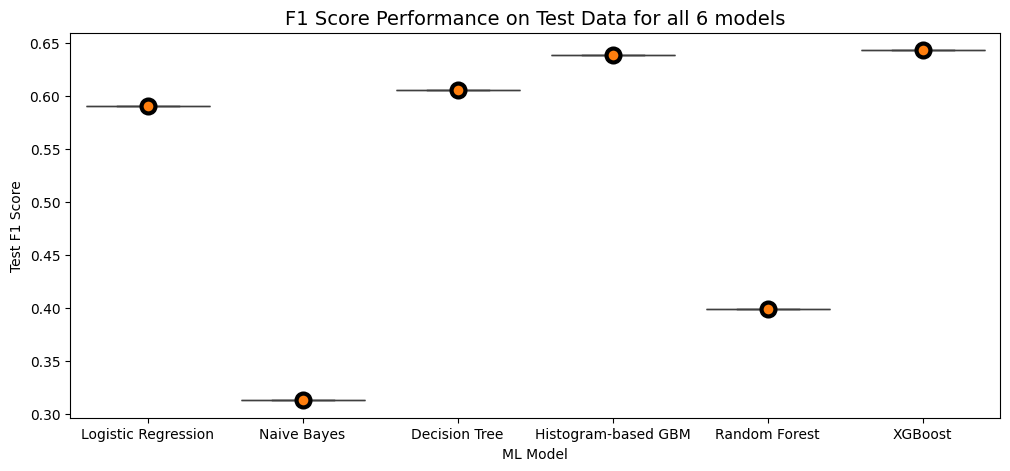

In [62]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="model", y="test_f1_score", data=df_output)
sns.stripplot(
    x="model",
    y="test_f1_score",
    data=df_output,
    linewidth=3,
    size=10,
    edgecolor="black",
    jitter=True,
)
plt.title("F1 Score Performance on Test Data for all 6 models", fontsize=14)
plt.xlabel("ML Model")
plt.ylabel("Test F1 Score")
plt.show()

# Best features using SHAP

In [63]:
shap.initjs()

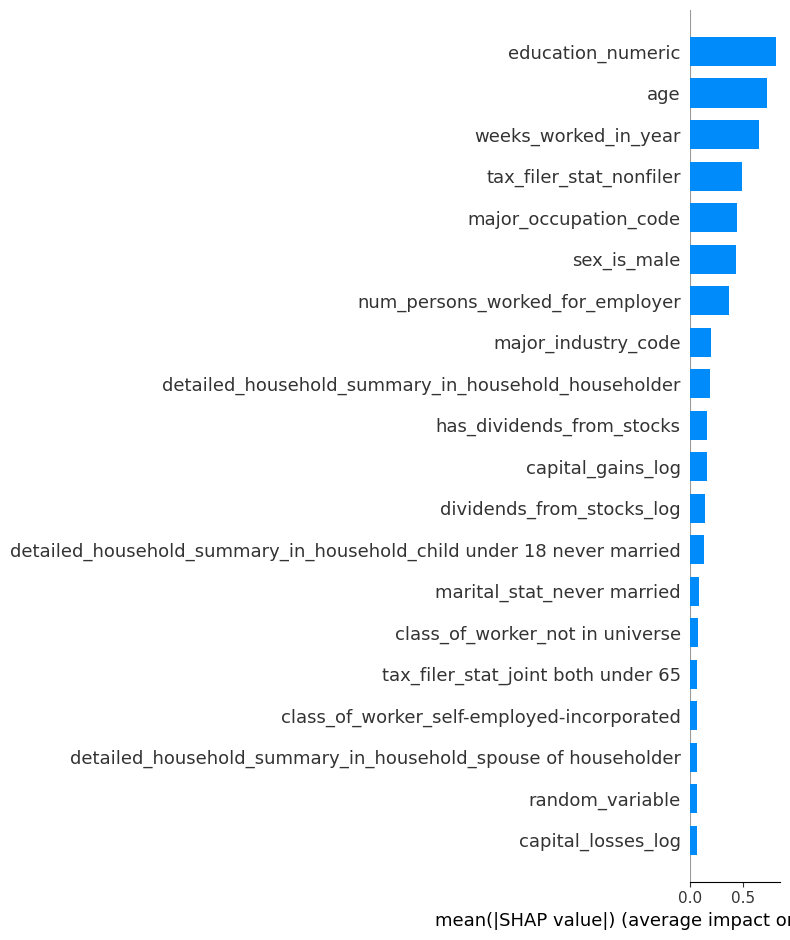

In [64]:
# SHAP from best model
explainer_object = shap.TreeExplainer(
    xgboost_model_object.named_steps["bayessearchcv"].best_estimator_,
    feature_names=feature_names,
)
shap_ = explainer_object.shap_values(
    xgboost_model_object["columntransformer"].transform(X_test)
)

shap.summary_plot(
    shap_,
    xgboost_model_object["columntransformer"].transform(X_test),
    feature_names=feature_names,
    plot_type="bar",
)

### Methodology:



*   Since the data is imbalanced, accuracy is not the best metric for evaluating results. Thus, created additional functions to get the F-1 score, AUC-ROC graph and the PR curve.
*   The first step for building the models was to create a pipeline for processing followed by hyper parameter tuning using BayesSearch CV
*   The XGBoost model and the histogram based GBM provided the best results on both train and test datasets



### Next Steps:

* Since the data is imbalanced, adding more data will improve the metrics for some of the models
* Advanced cloud resources can be useful in building deep learning models in this scenario
* Neural networks can provide better results, so trying deep learning models can improve the model metric .